In [1]:
%plot inline -s 640,480
workspace;

# Test cluster stability with curlies_bridges_nostim22-Mar-2017.mat

In [3]:
% Load the data
clear
load('curlies_bridges_nostim22-Mar-2017.mat', 'sim_nostim')
z = sim_nostim{1}.networkHistory.V_soma;

% Remove the beginning for better processing
z1 = double(z(:, 5000:end)');

% Data without a dc component
z2 = bsxfun(@minus, z1, mean(z1,1));

Here we first remove the non-oscllating cells.

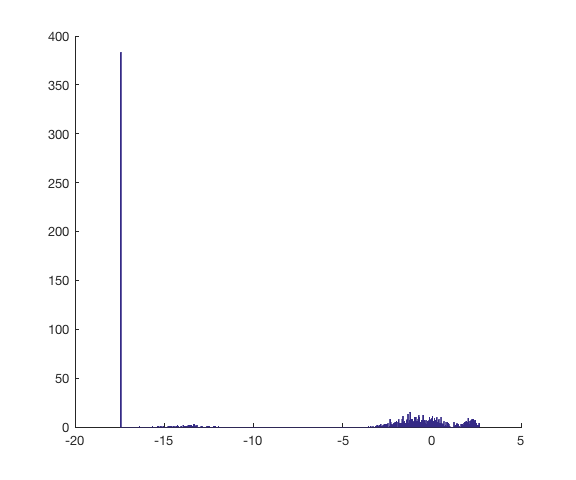

In [4]:
z3 = hilbert(z2);
logamp = log(mean(abs(z3)));
hist(logamp, 500)
box off

Two peaks at the end are from non-oscillating cells. We remove them from our data...

In [7]:
igood = find(logamp>=-5.4);
ibad = find(logamp<-5.4);

z4 = z2(:,igood);
%plot(z2(:,ibad))

Now we compute the normalized data and (partial) correlation matrix.

In [10]:
z4 = bsxfun(@times, z4, 1./std(z4)); % Normalize the amplitude as well
z4m = mean(z4, 2);

% zn = (z4'*z4)/size(z4, 1); % either correlation
zn = partialcorr(z4, z4m); % partial correlation w.r.t the mean oscillation
zn(zn<0) = 0; % Ignore negative correlation...

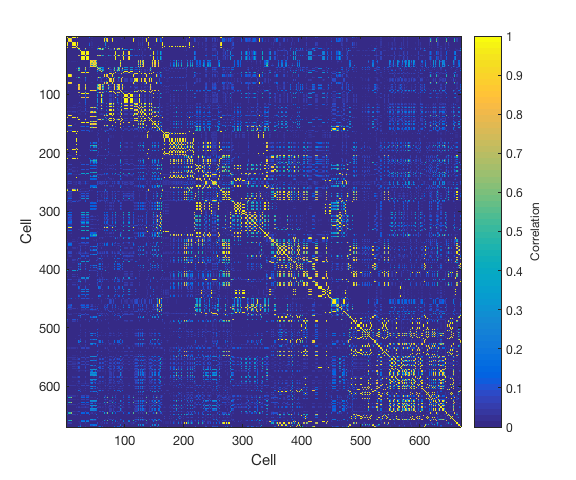

In [11]:
imagesc(zn)
xlabel('Cell')
ylabel('Cell')
c = colorbar();
c.Label.String = 'Correlation';

## Cluster stability

*Cluster stability* is a non-parametric method to determine the best number of clusters. First, we make $N_{shuffle}$ data sets from randomly drawn samples (a fraction of 80% below), obtain cluster labels with a given number of clusters for each resampled data set, and compare how well they match with each other.

In [12]:
Nshuffle = 50;
[zn2, idxz] = make_rand_samples2(zn, Nshuffle, 0.8);

In [13]:
v = spctcldata(zn);
vs = cellfun(@spctcldata, zn2, 'UniformOutput', false);

Now, we evaluate the distance of clustering results between each pair of random sample, with changing the number of clusters from 2 to 120.

In [ ]:
ngrid = 120 - 1;
met = zeros(ngrid, Nshuffle*(Nshuffle-1)/2);
rmet = zeros(ngrid, Nshuffle*(Nshuffle-1)/2);
fprintf('i, Ncl\n');
for i=1:ngrid
    Ncl = i+1;
    
    % Perform clustering on the random samples
    clidx = arrayfun(@(k) spctcl(vs{k}, Ncl, 1), 1:Nshuffle, 'UniformOutput', false);
    
    % Evaluate distance between each pair
    [pd, rpd] = cij2(clidx, idxz);
    met(i,:) = pd;
    rmet(i,:) = rpd;
    
    fprintf('%d, %d\n', i, Ncl);
end

`met` and `rmat` are the cosine distances $d$ for the actual and randomized (control) data. We correct for the data and label size effect by using `rmet` and compute the stability $S=1-d_{corrected}$. It turned out that $S$ maximizes when $N_{cluster}=30$.

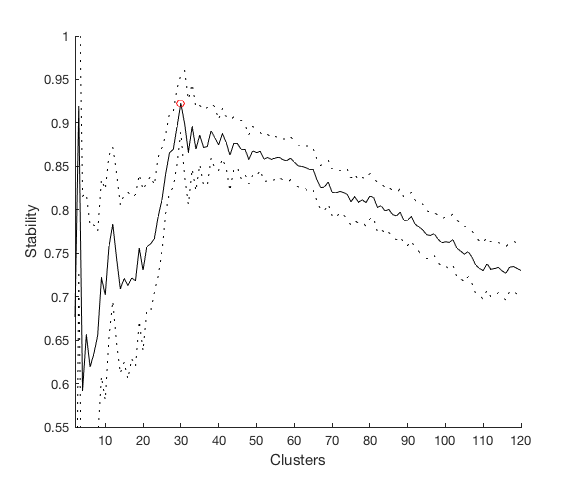

In [16]:
tcl = 2:120;

mmet = 1-mean(met'./rmet');
sdmet = std(met'./rmet');
plot(tcl, mmet+sdmet,':k',...
     tcl, mmet-sdmet,':k',...
     tcl, mmet,'k',...
     [30], mmet(30-1),'or')
box off
axis tight
ylim([0.55 1])
xlabel('Clusters')
ylabel('Stability')

The correlation matrix looks nice when $N_{cluster}=30$.

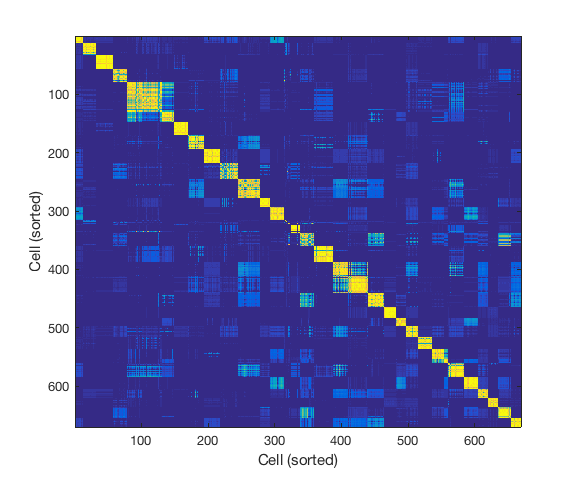

In [17]:
ncl = 30;
idx = spctcl(v, ncl, 20); %Recluster the data
[~, sidx] = sort(idx);
imagesc(zn(sidx, sidx))
xlabel('Cell (sorted)')
ylabel('Cell (sorted)')

Examining the membrane potentials for each cluster shows that clustering is mostly driven by locking at different phases.

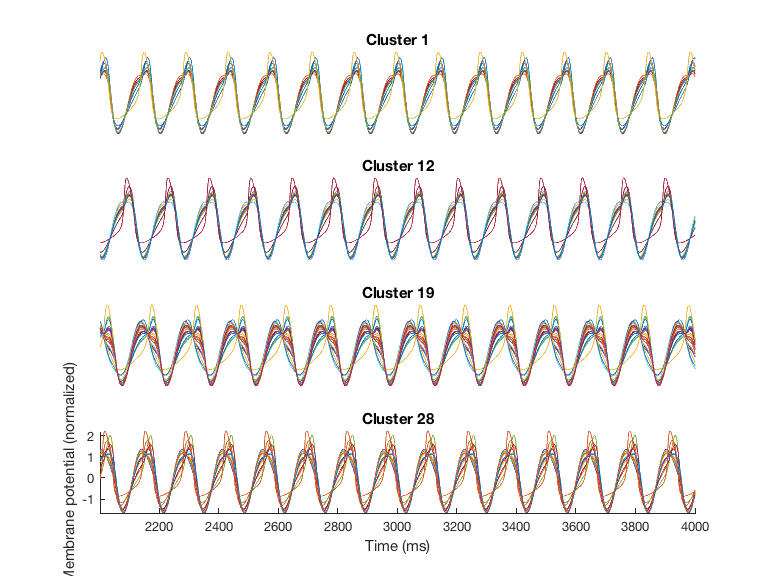

In [19]:
%plot inline -s 800,600
tt = 2001:4000;
subplot(411)
plot(tt, z4(tt, idx==1))
axis tight
box off
axis off
title('Cluster 1')
subplot(412)
plot(tt, z4(tt, idx==12))
axis tight
box off
axis off
title('Cluster 12')
subplot(413)
plot(tt, z4(tt, idx==19))
axis tight
box off
axis off
title('Cluster 19')
subplot(414)
plot(tt, z4(tt, idx==28))
axis tight
box off
title('Cluster 28')
ylabel('Membrane potential (normalized)')
xlabel('Time (ms)')

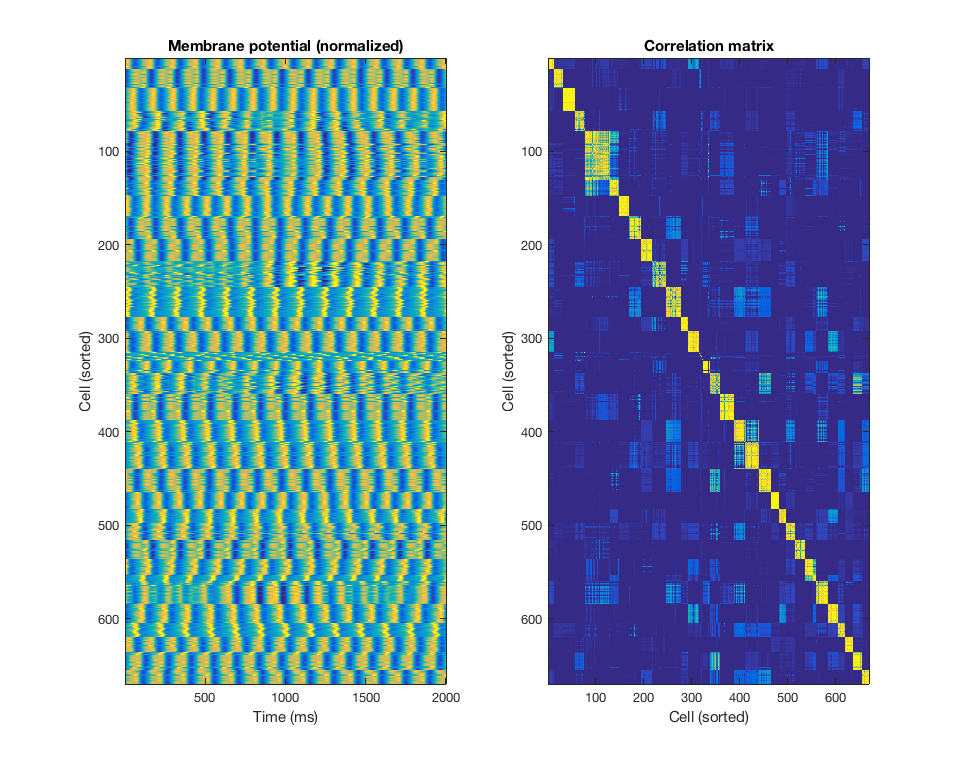

In [20]:
%plot inline -s 1000,800
subplot(121)
imagesc(z4(2000:4000, sidx)')
xlabel('Time (ms)')
ylabel('Cell (sorted)')
caxis([-2 2])
title('Membrane potential (normalized)')
subplot(122)
imagesc(zn(sidx, sidx))
xlabel('Cell (sorted)')
ylabel('Cell (sorted)')
title('Correlation matrix')